##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# TF Hub for TF2: Image Module Retraining (preview)

<table align="left">
<td align="center">
  <a target="_blank"  href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" /><br>Run in Google Colab
  </a>
</td>
<td align="center">
  <a target="_blank"  href="https://github.com/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /><br>View source on GitHub</a>
</td>
</table>

This Colab offers a preview of using TensorFlow Hub modules in the native TF2 format with Keras. It uses a pre-trained image feature vector module for classifying five species of flowers, including fine-tuning of the module.

**NOTE:** No stable versions of TF2 and TF Hub for TF2 have been released at this point. This colab needs PIP package `tensorflow-hub>=0.3.0` to run.

## Set up library versions for TF2

In [1]:
!pip install -U --pre tensorflow-gpu --quiet

    100% |████████████████████████████████| 332.1MB 70kB/s 
    100% |████████████████████████████████| 419kB 13.6MB/s 
    100% |████████████████████████████████| 61kB 15.3MB/s 
    100% |████████████████████████████████| 3.0MB 8.7MB/s 


In [2]:
!pip install 'tensorflow-hub>=0.3'

In [3]:
from __future__ import absolute_import, division, print_function

import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.0.0-alpha0
Eager mode:  True
Hub version:  0.4.0
GPU is available


## Select the Hub/TF2 module to use

Hub modules for TF 1.x won't work here, please use one of the selections provided.

In [4]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 32 #@param {type:"integer"}

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2 with input size (224, 224) and output dimension 1280


## Set up the Flowers dataset

Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

In [5]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

228818944/228813984 [==============================] - 2s 0us/step


In [7]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False,
    target_size=IMAGE_SIZE, batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True,
    target_size=IMAGE_SIZE, batch_size=BATCH_SIZE)


Found 731 images belonging to 5 classes.
Found 2939 images belonging to 5 classes.



## Defining the model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [0]:
do_fine_tuning = False #@param {type:"boolean"}

In [9]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE, output_shape=[FV_SIZE],
                   trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  2257984   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


## Training the model

In [0]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
  metrics=['accuracy'])

In [11]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit_generator(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/5
91/91 [==============================] - 44s 485ms/step - loss: 1.1466 - accuracy: 0.5081 - val_loss: 0.8746 - val_accuracy: 0.8310
Epoch 2/5
91/91 [==============================] - 39s 429ms/step - loss: 0.9179 - accuracy: 0.7967 - val_loss: 0.8096 - val_accuracy: 0.8509
Epoch 3/5
91/91 [==============================] - 38s 423ms/step - loss: 0.8505 - accuracy: 0.8308 - val_loss: 0.8051 - val_accuracy: 0.8551
Epoch 4/5
91/91 [==============================] - 37s 404ms/step - loss: 0.8359 - accuracy: 0.8403 - val_loss: 0.8222 - val_accuracy: 0.8480
Epoch 5/5
91/91 [==============================] - 38s 421ms/step - loss: 0.8605 - accuracy: 0.8389 - val_loss: 0.8129 - val_accuracy: 0.8423


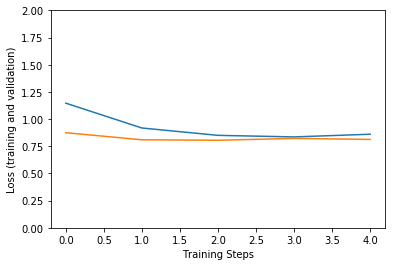

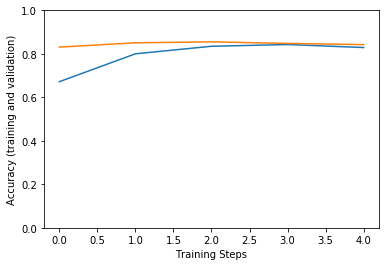

In [12]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])